In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Process accented characters
import unicodedata

# NLTK
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_nltk = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer=WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Overview

In [2]:
# Read in the csv file
df = pd.read_csv("../data/cuisine_full_ingredients.csv")

In [3]:
# Overview of the data set
df.sample(10, random_state=2)

,cuisine,recipe,full_ingredients
3727,Italian,Spicy fregola with scallops and crispy kale,"['olive oil, for shallow and deep frying', '1 ..."
1923,Chinese,Chunky bacon and cucumber salad,"['1 tbsp groundnut oil', '6 long dried chillie..."
3552,Italian,Polenta pork,"['2 tbsp sunflower oil ', '12 rashers thick ri..."
1146,British,Oat fig stuffing,"['140g/5oz butter', '100g/3½oz jumbo oats', '1..."
3195,Italian,Bolognese with tagliatelle,"['250g/9oz 00 flour', '3-4 medium free-range e..."
1643,British,Textured potato salad,"['675g/1½lb floury potatoes, peeled and cut in..."
3054,Indian,Tandoori lamb wrap,"['150ml/5fl oz Greek-style yoghurt ', '½ small..."
842,British,Gammon and pease pudding,"['300g/10oz dried yellow split peas', '50g/2oz..."
505,British,Braised shin of beef with parsnip purée,"['4kg/9lb beef shin, on the bone', 'sea salt a..."
2224,French,Mary Berry's celeriac remoulade,"['650g/1lb 7oz celeriac, peeled and sliced int..."


In [4]:
# There are no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cuisine           4724 non-null   object
 1   recipe            4724 non-null   object
 2   full_ingredients  4724 non-null   object
dtypes: object(3)
memory usage: 110.8+ KB


In [5]:
print(f"There are {df.cuisine.nunique()} cuisines represented in the dataset.")

There are 22 cuisines represented in the dataset.


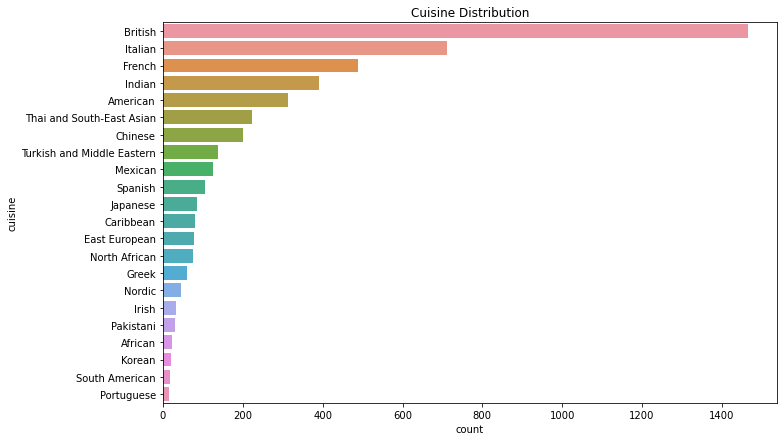

In [6]:
# Visualise cuisine distribution
y = df.cuisine
plt.figure(figsize=(11,7))
sns.countplot(y=y, order=y.value_counts().reset_index()["index"])
plt.title("Cuisine Distribution")
plt.show()

In [7]:
# Class distribution in the dataset
df.cuisine.value_counts()/df.shape[0]

British                       0.309907
Italian                       0.150720
French                        0.103302
Indian                        0.082769
American                      0.066046
Thai and South-East Asian     0.047417
Chinese                       0.042549
Turkish and Middle Eastern    0.029001
Mexican                       0.026461
Spanish                       0.022439
Japanese                      0.017993
Caribbean                     0.017146
East European                 0.016300
North African                 0.016088
Greek                         0.012913
Nordic                        0.009526
Irish                         0.006774
Pakistani                     0.006351
African                       0.004869
Korean                        0.004445
South American                0.003810
Portuguese                    0.003175
Name: cuisine, dtype: float64

As can be seen, the cuisine classification is imbalanced with the highest number of recipes in British cuisine. This can be explained because the data has been scraped from a website in uk. The top player is followed by Italian, French, and Indian cuisines. The least represented cuisines are the Korean, South American, and Portuguese recipes.

Let's take only column cuisine and full_ingredients

In [8]:
df = df[["cuisine", "full_ingredients"]]
df.shape

(4724, 2)

## Text cleaning

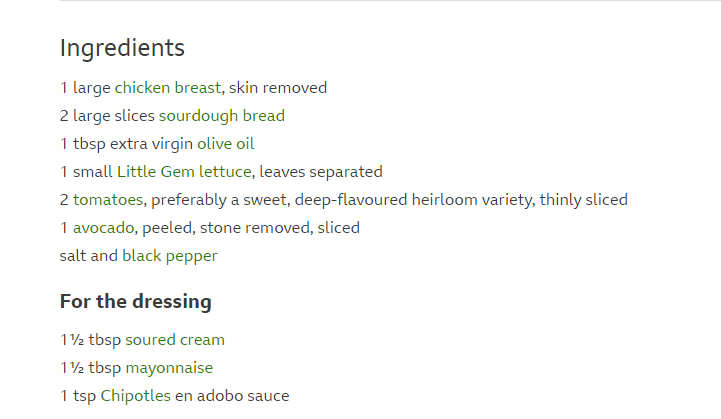
<div style="text-align: right"> (Image source: https://www.bbc.co.uk/food/recipes/californian_sourdough_59703) </div>

The above text image illustrates how a typical list of ingredients looks like. As I'm interested in a multi-class classification problem, I'd need to lowercase, remove special characters including digits, and text with digits, etc. As the data is from a well-known website, I assume that there are very few spelling errors.

In [9]:
# Convert to lowercase

df.full_ingredients = df.full_ingredients.str.lower()

### Special characters

In [10]:
# To investigate special characters (including digits) in the full_ingredients
## Let's firstly mix all text in the full_ingredients column into a list

[x for x in df.full_ingredients][:2]

["['2 large red or orange peppers, de-seeded and cut into bite-sized chunks', '2 sweet potatoes, scrubbed and cut into bite-sized chunks', '2 red onions, cut into bite-sized chunks', '200g/7oz cherry tomatoes', '1 tbsp harissa spice mix', '1 tbsp olive oil', 'sea salt and freshly ground black pepper']",
 "['350g/12oz dried black-eyed beans', '900g/2lb sirloin steak, cut into 1cm/½ in cubes', '325ml/11½fl oz vegetable oil', '1 large onion, chopped', '4 garlic cloves, finely chopped', '4cm/2in piece fresh root ginger, grated', '1 tsp dried chilli flakes', '2 x 400g tins chopped tomatoes', '2 tbsp tomato purée', '2 beef stock cubes', '2 sprigs fresh thyme', '1 scotch bonnet chilli, chopped', '3 ripe plantain, peeled and sliced', 'salt and freshly ground black pepper']"]

In [11]:
## Then seperate the texts into characters
characters = [char for ing_list in df.full_ingredients for char in ing_list]
characters[:15]

['[', "'", '2', ' ', 'l', 'a', 'r', 'g', 'e', ' ', 'r', 'e', 'd', ' ', 'o']

In [12]:
# Create a function to get unique special characters
def unique_special_chars():
    remaining_characters = [char for ing_list in df.full_ingredients for char in ing_list]
    outcome = ' '.join(sorted([char for char in set(
        remaining_characters) if re.findall('[^ a-z]', char)]))
    return outcome

In [13]:
# Get a set of unique characters, exclude a to z and whitespace, then sort them in order
unique_special_chars()

'! " % & \' ( ) , - . / 0 1 2 3 4 5 6 7 8 9 : ; [ \\ ] ` £ ¼ ½ ¾ × â ã ä ç è é ê î ï ñ ó ô û ü ō ư ấ ớ – ‘ ’ “ ” ⁄ ⅓ ⅔ ⅛ ⅜ ⅝'

Firstly, let's remove all of the digits (including fractions like `¼`) and words with digits (e.g. `900g/2lb`).

In [14]:
df.full_ingredients = df.full_ingredients.str.replace(r'\w*[\d¼½¾⅓⅔⅛⅜⅝]\w*', '')

Then remove the punctuations.

In [15]:
print(f"Possible punctuations to be removed {string.punctuation}")

Possible punctuations to be removed !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In the above list, `'` can be like quotation marks wrapping around an ingredient or apostrophes. Apostrophes `'` or `’` have three main uses:
1. To indicate possession
2. To indicate a word contraction (e.g. `do not` to `don't`)
3. To separate the s from plural letters/numbers and abbreviations followed by periods

As the dataset's main features are ingredient names (in noun form), word contraction should not be an issue. I'll simply drop `'` and `’`. Although this approach is not perfect, e.g. `lamb’s` will become `lambs`, I'll later apply other techniques like stemming or lemmatization to map most of the different forms of a word to its base word.

In [16]:
# Create a function to get examples covering a character
def examples_for_character(rule):
    outcome = list(set([word for ing_list in df.full_ingredients for word in ing_list.split(
        " ") if re.findall(rule, word)]))
    return outcome

Following are some examples of some sets of characters with `'` or `’`

In [17]:
examples_for_character("['’]")[:30]

["'micro",
 "saucepan',",
 "'seasoned",
 "'sea-salt",
 "biscuits)',",
 'doesn’t',
 "royal)',",
 "cubes',",
 "scissors',",
 "'burger",
 "tamarind',",
 "anise',",
 "drizzle',",
 "roses',",
 "flambé',",
 "frozen)',",
 "wraps',",
 "'basmati",
 "'sweetcorn",
 "'snipped",
 "bind',",
 "steak',",
 "split',",
 "washed',",
 "whipped']",
 "'blinis',",
 "'crushed",
 "conserve']",
 "speck)',",
 "made)',"]

In [18]:
# Remove punctuations
df.full_ingredients = df.full_ingredients.str.translate(str.maketrans('', '', string.punctuation))

In [19]:
# Review some ingredient text up to this step
[x for x in df.full_ingredients][:2]

[' large red or orange peppers deseeded and cut into bitesized chunks  sweet potatoes scrubbed and cut into bitesized chunks  red onions cut into bitesized chunks  cherry tomatoes  tbsp harissa spice mix  tbsp olive oil sea salt and freshly ground black pepper',
 ' dried blackeyed beans  sirloin steak cut into  in cubes  oz vegetable oil  large onion chopped  garlic cloves finely chopped  piece fresh root ginger grated  tsp dried chilli flakes  x  tins chopped tomatoes  tbsp tomato purée  beef stock cubes  sprigs fresh thyme  scotch bonnet chilli chopped  ripe plantain peeled and sliced salt and freshly ground black pepper']

Let's examine the remaining special characters.

In [20]:
unique_special_chars()

'£ × â ã ä ç è é ê î ï ñ ó ô û ü ō ư ấ ớ – ‘ ’ “ ” ⁄'

Let's examine sets of characters with `£`, `×`, `–`, and `⁄`

In [21]:
examples_for_character("[£×–⁄]")

['⁄',
 'litres–',
 '––wide',
 'small–medium',
 '–',
 '––',
 'litre–',
 'oz–',
 'medium–hot',
 'cm–',
 'self–raising',
 '£',
 'medium–large',
 '×']

Similarly to my approach with `'` as explained before, let's just trim `£`, `×`, `–`, and `⁄` from the above words.

In [22]:
df.full_ingredients = df.full_ingredients.str.replace(r'[£×–⁄]', '')

Next, let's examine words with `‘`, `’`, `“`, and `”` characters.

In [23]:
examples_for_character("[‘’“”]")

['‘suyannaise’',
 'bird’seye',
 '’nduja',
 'goats’',
 'quails’',
 'you’d',
 'doesn’t',
 'cow’s',
 'smoke’',
 '“boston',
 'd’or',
 '‘ladyfinger’',
 '‘medium’',
 '‘picante’',
 '‘mozzarellastyle’',
 'gentleman’s',
 'bird’s',
 '‘gluelike',
 '‘butter’',
 'monk’s',
 'butt”',
 '‘milk’',
 'goat’s',
 'za’atar',
 'sheep’s',
 '‘’',
 'cows’',
 'd’auvergne',
 'ladies’',
 'jacob’s',
 'cheese’',
 '“”',
 '“flats”',
 'sheeps’',
 'don’t',
 'pimm’s',
 '‘cream',
 '‘liquid',
 'd’ambert',
 'paste’',
 'bull’s',
 'd’espelette',
 'can’t',
 'lambs’',
 '‘feed’',
 'man’s',
 'lamb’s',
 'cox’s',
 'calf’s',
 '“drumettes”',
 'pig’s',
 'birds’eye']

Similarly to my approach with `'` as explained before, let's just trim `‘`, `’`, `“`, and `”` from the above words.

In [24]:
df.full_ingredients = df.full_ingredients.str.replace(r'[‘’“”]', '')

Let's examine the remaining special characters.

In [25]:
unique_special_chars()

'â ã ä ç è é ê î ï ñ ó ô û ü ō ư ấ ớ'

Let's have a closer look at words that have characters `â ã ä ç è é ê î ï ñ ó ô û ü ō ư ấ ớ`

In [26]:
examples_for_character("[âãäçèéêîïñóôûüōưấớ]")

['béchamel',
 'ximénez',
 'velouté',
 'ñora',
 'gruyère',
 'padrón',
 'fraïche',
 'chấm',
 'frâiche',
 'crêpes',
 'pimentón',
 'ibérico',
 'pressé',
 'glacés',
 'croûtons',
 'gewürztraminer',
 'compôte',
 'desirée',
 'désirée',
 'créme',
 'niçoise',
 'glacé',
 'flambéeing',
 'purée',
 'côte',
 'shōga',
 'sautéed',
 'fraîche',
 'patissière',
 'spreadpurée',
 'jalapeños',
 'aïoli',
 'soufflé',
 'västerbotten',
 'nước',
 'épices',
 'rosé',
 'suprêmes',
 'pâté',
 'pimentão',
 'jamón',
 'consommé',
 'pouillyfumé',
 'frisée',
 'flambé',
 'crème',
 'comté',
 'gruyére',
 'cépe',
 'pureé',
 'jalapeño',
 'purèe',
 'puréed']

The above words have [accented characters](https://www.fonts.com/content/learning/fontology/level-3/signs-and-symbols/accents). They are important elements in both written and spoken language. They might be considered as "borrowed" words in English, sometimes helping to clarify the meaning of a word which might be different without the accent. Accents might get induced due to a keyboard default setting or typing style. As I'm analysing text in English, it would be more helpful to convert these words into ASCII characters. 

In [27]:
# Create a function to remove accented characters
def remove_accented_chars(matchobj):
    text = matchobj.group()
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

In [28]:
# Remove accented characters in the full_ingredients
df.full_ingredients = df.full_ingredients.apply(
    lambda x: re.sub(r'[âãäçèéêîïñóôûüōưấớ]', remove_accented_chars, x))

In [29]:
# Try some random examples to test
print(f"The number of word 'pureé' is {df.full_ingredients.str.contains('pureé').sum()}.")
print(f"The number of word 'puree' is {df.full_ingredients.str.contains('puree').sum()}.")
print(f"The number of word 'jalapeños' is {df.full_ingredients.str.contains('jalapeños').sum()}.")
print(f"The number of word 'jalapenos' is {df.full_ingredients.str.contains('jalapenos').sum()}.")

The number of word 'pureé' is 0.
The number of word 'puree' is 337.
The number of word 'jalapeños' is 0.
The number of word 'jalapenos' is 4.


In [30]:
# Check remaining special characters
unique_special_chars()

''

There are no special characters left.

In [31]:
# Overview of the dataframe after cleaning and preprocessing
df.sample(10, random_state=2)

,cuisine,full_ingredients
3727,Italian,olive oil for shallow and deep frying shallot...
1923,Chinese,tbsp groundnut oil long dried chillies tsp...
3552,Italian,tbsp sunflower oil rashers thick rindless s...
1146,British,butter jumbo oats rolled oats red onions r...
3195,Italian,flour medium freerange eggs preferably with...
1643,British,floury potatoes peeled and cut into cubes ...
3054,Indian,oz greekstyle yoghurt small onion roughly c...
842,British,dried yellow split peas butter onion roughl...
505,British,beef shin on the bone sea salt and freshly gr...
2224,French,celeriac peeled and sliced into thin matchst...


## Pre-Processing

### Word tokenization

In [32]:
df.full_ingredients = df.full_ingredients.apply(lambda x: word_tokenize(x))
df.full_ingredients[:10]

0    [large, red, or, orange, peppers, deseeded, an...
1    [dried, blackeyed, beans, sirloin, steak, cut,...
2    [oz, olive, oil, onion, chopped, garlic, clove...
3    [butter, for, greasing, oz, fullfat, milk, fre...
4    [tbsp, olive, oil, onion, thinly, sliced, garl...
5    [tbsp, vegetable, oil, tsp, cumin, seeds, tsp,...
6    [tsp, cloves, tsp, fennel, seeds, tsp, black, ...
7    [tbsp, olive, oil, large, onions, sliced, bone...
8    [peppercorns, cardamom, pods, cloves, tbsp, oi...
9    [salt, tsp, coriander, seeds, tsp, fennel, see...
Name: full_ingredients, dtype: object

### Remove stop words

In [33]:
df.full_ingredients = df.full_ingredients.apply(lambda x: [word for word in x if not word in stop_words_nltk])
df.full_ingredients[:10]

0    [large, red, orange, peppers, deseeded, cut, b...
1    [dried, blackeyed, beans, sirloin, steak, cut,...
2    [oz, olive, oil, onion, chopped, garlic, clove...
3    [butter, greasing, oz, fullfat, milk, fresh, w...
4    [tbsp, olive, oil, onion, thinly, sliced, garl...
5    [tbsp, vegetable, oil, tsp, cumin, seeds, tsp,...
6    [tsp, cloves, tsp, fennel, seeds, tsp, black, ...
7    [tbsp, olive, oil, large, onions, sliced, bone...
8    [peppercorns, cardamom, pods, cloves, tbsp, oi...
9    [salt, tsp, coriander, seeds, tsp, fennel, see...
Name: full_ingredients, dtype: object

### Lemmatization

Lemmatization refers to the process of mapping all different variants of a word to its base word.

In [34]:
df.full_ingredients = df.full_ingredients.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df.full_ingredients[:10]

0    [large, red, orange, pepper, deseeded, cut, bi...
1    [dried, blackeyed, bean, sirloin, steak, cut, ...
2    [oz, olive, oil, onion, chopped, garlic, clove...
3    [butter, greasing, oz, fullfat, milk, fresh, w...
4    [tbsp, olive, oil, onion, thinly, sliced, garl...
5    [tbsp, vegetable, oil, tsp, cumin, seed, tsp, ...
6    [tsp, clove, tsp, fennel, seed, tsp, black, mu...
7    [tbsp, olive, oil, large, onion, sliced, bonel...
8    [peppercorn, cardamom, pod, clove, tbsp, oil, ...
9    [salt, tsp, coriander, seed, tsp, fennel, seed...
Name: full_ingredients, dtype: object

take a look at bag of words and bag of n-grams --> bi and tri-grams --> common words --> wordcloud/barchar for most popular ingredients in each cuisines/all cuisines

It seems that salt is the most commonly used ingredient which is not surprising at all! We also find water, onions, garlic and olive oil - not so surprising also . Salt is such a common ingredient that we expect it to have poor predictive power in recognizing the type of cuisine We will remove salt and some other common ingredients from the mix to make our model do better

## Bags of Words and Bags of N-Grams

### Remove words with less than 2 characters

### Remove measuring units